# Deploying Your Model
In this exercise, we'll expose new images to our model and see how it does

## Loading the Model
Let's load the saved model that we trained. Modify the code below to point to the model you select.  

In [3]:
from tensorflow import keras
import argparse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import horovod.keras as hvd
from keras import backend as K
import keras.optimizers

In [5]:
# note that you will need to update this model name 
model = keras.models.load_model('optimized-model/b2_e30/model_b2_e30_augtrue_fttrue.h5')

2024-12-05 11:46:04.743499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13750 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:60:00.0, compute capability: 7.5
2024-12-05 11:46:04.745480: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13750 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:61:00.0, compute capability: 7.5


If you'd like to, you can see the summary of the model.

In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 149)               76437     
                                                                 
Total params: 14791125 (56.42 MB)
Trainable params: 14791125 (56.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Showing the Images

When we use our model to make predictions on new images, it will be useful to show the image as well. We can use the matplotlib library to do this.

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

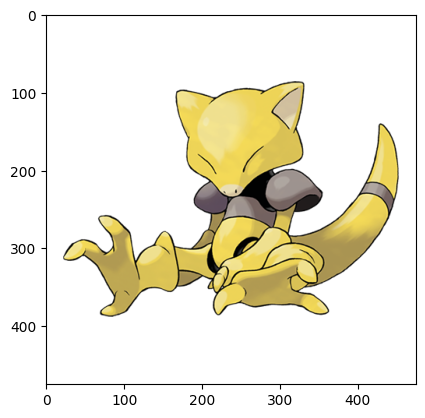

In [8]:
#uncomment the lines below to see a few of the testing set images
#Can change to pokemon images

data_dir = '/home/woodm/CSC2611/pokemon-image-classifier/data/'

# show_image(data_dir + 'Abra/00000000.png')

### Scaling the Images

The images in our dataset were 224x224 pixels. We need to make sure to pass the same size images into our method for prediction. There are a few ways to edit images with Python, but Keras has a built-in utility that works well. 

In [9]:
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

def load_and_scale_image(image_path):
    image = image_utils.load_img(image_path, target_size=(224,224))
    return image

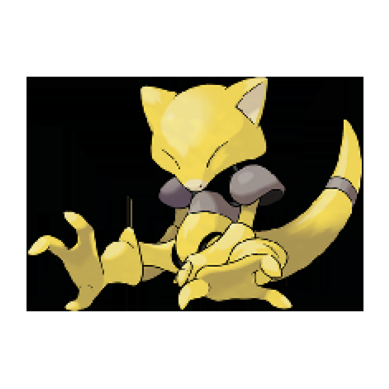

In [10]:
image = load_and_scale_image(data_dir + 'Abra/00000000.png')
# image = load_and_scale_image('../data/Alakazam/.png')
# image = load_and_scale_image('../data/.png')
# image = load_and_scale_image('../data/.png')
# image = load_and_scale_image('../data/.png')
# image = load_and_scale_image('../data/.png')
plt.axis('off')
plt.imshow(image)

### Preparing the Image for Prediction

Now that we have the right size image, we're close to being ready to pass it into our model for prediction. First we need to reshape our image to match the shape of the dataset the model was trained on. Before we can reshape, we need to convert our image into a more rudimentary format. We'll do this with a keras utility called image_to_array.

In [11]:
image = image_utils.img_to_array(image)

In [12]:
print(f"Original image shape: {image.shape}")


Original image shape: (224, 224, 3)


Now we can reshape our image and scale it (preprocess) to get it ready for prediction.

In [13]:
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

## Making Predictions

Okay, now we're ready to predict! This is done by passing our pre-processed image into the model's predict method. 

In [14]:
prediction = model.predict(image)
print(prediction)

2024-12-05 11:50:32.140857: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100


1/1 [==============================] - 2s 2s/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  8.0191516e-23 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+0

### Understanding the Prediction

The predictions are in the format of a length 6 array. Each element of the array is a probability between 0 and 1, representing the confidence for each category. Let's make it a little more readable. We can start by finding which element of the array represents the highest probability. Fill in the following cell using numpy to find the largest value.  

In [15]:
np.argmax(prediction)

56

In [35]:
import os

# Specify the path to the 'data' folder in the parent directory
data_path = "/home/woodm/CSC2611/pokemon-image-classifier/data"

# Check if the directory exists
if os.path.exists(data_path) and os.path.isdir(data_path):
    # Get all folder names in the specified path
    folders = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]
    
    # Create a dictionary with incremental keys starting from 1
    dictionary = {index: folder for index, folder in enumerate(sorted(folders))}
    
    # Print the resulting dictionary
    print(dictionary)
    
else:
    print(f"Directory {data_path} does not exist or is not accessible.")

{0: 'Abra', 1: 'Aerodactyl', 2: 'Alakazam', 3: 'Arbok', 4: 'Arcanine', 5: 'Articuno', 6: 'Beedrill', 7: 'Bellsprout', 8: 'Blastoise', 9: 'Bulbasaur', 10: 'Butterfree', 11: 'Caterpie', 12: 'Chansey', 13: 'Charizard', 14: 'Charmander', 15: 'Charmeleon', 16: 'Clefable', 17: 'Clefairy', 18: 'Cloyster', 19: 'Cubone', 20: 'Dewgong', 21: 'Diglett', 22: 'Ditto', 23: 'Dodrio', 24: 'Doduo', 25: 'Dragonair', 26: 'Dragonite', 27: 'Dratini', 28: 'Drowzee', 29: 'Dugtrio', 30: 'Eevee', 31: 'Ekans', 32: 'Electabuzz', 33: 'Electrode', 34: 'Exeggcute', 35: 'Exeggutor', 36: 'Farfetchd', 37: 'Fearow', 38: 'Flareon', 39: 'Gastly', 40: 'Gengar', 41: 'Geodude', 42: 'Gloom', 43: 'Golbat', 44: 'Goldeen', 45: 'Golduck', 46: 'Golem', 47: 'Graveler', 48: 'Grimer', 49: 'Growlithe', 50: 'Gyarados', 51: 'Haunter', 52: 'Hitmonchan', 53: 'Hitmonlee', 54: 'Horsea', 55: 'Hypno', 56: 'Ivysaur', 57: 'Jigglypuff', 58: 'Jolteon', 59: 'Jynx', 60: 'Kabuto', 61: 'Kabutops', 62: 'Kadabra', 63: 'Kakuna', 64: 'Kangaskhan', 65: 'K

We can now pass in our prediction index to find the corresponding letter.

In [36]:
dictionary[np.argmax(prediction)]

'Abra'

In the next cell, we demonstrate how to find all the files in a directory that match a given pattern (png images).  For each of the 6 classes (e.g., apple, rotten apple, etc.) in our testing data set, alter the code below to calculate the accuracy of your model on that class. Report the accuracy per class along with the total number of images in the testing set for that class.

In [29]:
print(prediction.shape)
print(prediction)

(1, 149)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]


In [45]:
import glob
import os

# Set the directory and get its name dynamically
data_dir = '/home/woodm/CSC2611/pokemon-image-classifier/data'
current_dir = os.path.join(data_dir, 'Pikachu')
os.chdir(current_dir)

# Use the directory name as the label
label = os.path.basename(current_dir)

total = 0
correct = 0

# Define valid image file extensions
valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
all_files = [f for f in os.listdir() if f.lower().endswith(valid_extensions)]

for file in all_files:
    total += 1
    image = load_and_scale_image(file)
    image = image_utils.img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    prediction = model.predict(image)
    guess = dictionary[np.argmax(prediction)]
    print("Guess: " + guess)
    if guess == label:
        correct += 1

print(f"Accuracy: {correct / total:.2f}")
print(f"Total Images: {total}")

1/1 [==============================] - 0s 38ms/step
Guess: Pikachu
1/1 [==============================] - 0s 31ms/step
Guess: Pikachu
1/1 [==============================] - 0s 37ms/step
Guess: Pikachu
1/1 [==============================] - 0s 37ms/step
Guess: Pikachu
1/1 [==============================] - 0s 36ms/step
Guess: Pikachu
1/1 [==============================] - 0s 38ms/step
Guess: Pikachu
1/1 [==============================] - 0s 38ms/step
Guess: Pikachu
1/1 [==============================] - 0s 31ms/step
Guess: Pikachu
1/1 [==============================] - 0s 36ms/step
Guess: Pikachu
1/1 [==============================] - 0s 36ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 29ms/step
Guess: Pikachu
1/1 [==============================] - 0s 39ms/step
Guess: Pikachu
1/1 [==============================] - 0s 35ms/step
Guess: Pikachu
1/1 [==============================] - 0s 36ms/step
Guess: Pik

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Guess: Pikachu
1/1 [==============================] - 0s 29ms/step
Guess: Pikachu
1/1 [==============================] - 0s 37ms/step
Guess: Ivysaur
1/1 [==============================] - 0s 29ms/step
Guess: Vaporeon
1/1 [==============================] - 0s 29ms/step
Guess: Pikachu
1/1 [==============================] - 0s 34ms/step
Guess: Pikachu
1/1 [==============================] - 0s 35ms/step
Guess: Pikachu
1/1 [==============================] - 0s 29ms/step
Guess: Nidorina
1/1 [==============================] - 0s 34ms/step
Guess: Pikachu
1/1 [==============================] - 0s 29ms/step
Guess: Pikachu
1/1 [==============================] - 0s 29ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 33ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 31ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30m

1/1 [==============================] - 0s 29ms/step
Guess: Ivysaur
1/1 [==============================] - 0s 36ms/step
Guess: Vileplume
1/1 [==============================] - 0s 36ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 35ms/step
Guess: Weezing
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 29ms/step
Guess: Vaporeon
1/1 [==============================] - 0s 28ms/step
Guess: Porygon
1/1 [==============================] - 0s 34ms/step
Guess: Vaporeon
1/1 [==============================] - 0s 35ms/step
Guess: Pikachu
1/1 [==============================] - 0s 39ms/step
Guess: Pikachu
1/1 [==============================] - 0s 35ms/step
Guess: Nidorina
1/1 [==============================] - 0s 30ms/step
Guess: Nidorina
1/1 [==============================] - 0s 30ms/step
Gues

1/1 [==============================] - 0s 35ms/step
Guess: Pikachu
1/1 [==============================] - 0s 35ms/step
Guess: Vaporeon
1/1 [==============================] - 0s 30ms/step
Guess: Nidorina
1/1 [==============================] - 0s 37ms/step
Guess: Pikachu
1/1 [==============================] - 0s 35ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 31ms/step
Guess: Pikachu
1/1 [==============================] - 0s 29ms/step
Guess: Vaporeon
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 29ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Nidorina
1/1 [==============================] - 0s 37ms/step
Guess:

1/1 [==============================] - 0s 35ms/step
Guess: Pikachu
1/1 [==============================] - 0s 32ms/step
Guess: Pikachu
1/1 [==============================] - 0s 28ms/step
Guess: Pikachu
1/1 [==============================] - 0s 35ms/step
Guess: Pikachu
1/1 [==============================] - 0s 34ms/step
Guess: Pikachu
1/1 [==============================] - 0s 31ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 29ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Vaporeon
1/1 [==============================] - 0s 31ms/step
Guess: Nidorina
1/1 [==============================] - 0s 35ms/step
Guess: Nidorina
1/1 [==============================] - 0s 29ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Porygon
1/1 [==============================] - 0s 35ms/step
Guess: Slowpoke
1/1 [==============================] - 0s 31ms/step
Guess:

1/1 [==============================] - 0s 29ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 35ms/step
Guess: Pikachu
1/1 [==============================] - 0s 32ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Wigglytuff
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 34ms/step
Guess: Pikachu
1/1 [==============================] - 0s 36ms/step
Guess: Pikachu
1/1 [==============================] - 0s 31ms/step
Guess: Pikachu
1/1 [==============================] - 0s 35ms/step
Guess: Pikachu
1/1 [==============================] - 0s 35ms/step
Guess: Eevee
1/1 [==============================] - 0s 30ms/step
Guess: Nidorina
1/1 [==============================] - 0s 29ms/step
Guess: Pikachu
1/1 [==============================] - 0s 31ms/step
Guess: Vaporeon
1/1 [==============================] - 0s 35ms/step
Guess: 

1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 35ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 36ms/step
Guess: Pikachu
1/1 [==============================] - 0s 30ms/step
Guess: Tentacool
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 28ms/step
Guess: Pikachu
1/1 [==============================] - 0s 34ms/step
Guess: Vaporeon
1/1 [==============================] - 0s 35ms/step
Guess: Vaporeon
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 34ms/step
Guess: Vaporeon
1/1 [==============================] - 0s 30ms/step
Guess: Pikachu
1/1 [==============================] - 0s 31ms/step
Guess: Pikachu
1/1 [==============================] - 0s 35ms/step
Guess: Vaporeon
1/1 [==============================] - 0s 30ms/step
Gues